## EDA du dataset MUSDB18 
 Objectif :
 - Comprendre la structure du dataset MUSDB18 (train / test, formats, stems)
 - Analyser la distribution des durées des morceaux
 - Visualiser les signaux audio (mixture + stems)
 - Étudier l'énergie et contribution relative des instruments


### imports

In [1]:
!pip install musdb stempeg librosa numpy pandas matplotlib tqdm


In [ ]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import musdb             
import librosa
import librosa.display
from tqdm import tqdm

In [ ]:
MUSDB_ROOT = Path("./musdb18")  
mus_train = musdb.DB(root=str(MUSDB_ROOT), subsets="train", is_wav=False)
mus_test = musdb.DB(root=str(MUSDB_ROOT), subsets="test", is_wav=False)
len_train = len(mus_train)
len_test = len(mus_test)
len_train, len_test


(100, 50)

**Tableau récapitulatif des morceaux:**

In [3]:
def collect_track_info(mus_db, subset_name):
    rows = []
    for track in mus_db:
        audio = track.audio
        sr = track.rate
        duration_sec = audio.shape[0] / sr

        rows.append(
            dict(
                name=track.name,
                subset=subset_name,
                duration_sec=duration_sec,
                duration_min=duration_sec / 60.0,
                path=track.path,
                sample_rate=sr ) )
    return rows

rows_train = collect_track_info(mus_train, "train")
rows_test = collect_track_info(mus_test, "test")

df_tracks = pd.DataFrame(rows_train + rows_test)
df_tracks.head()


,name,subset,duration_sec,duration_min,path,sample_rate
0,A Classic Education - NightOwl,train,171.247166,2.854119,musdb18\train\A Classic Education - NightOwl.s...,44100
1,ANiMAL - Clinic A,train,237.865215,3.964420,musdb18\train\ANiMAL - Clinic A.stem.mp4,44100
2,ANiMAL - Easy Tiger,train,205.473379,3.424556,musdb18\train\ANiMAL - Easy Tiger.stem.mp4,44100
3,ANiMAL - Rockshow,train,165.511837,2.758531,musdb18\train\ANiMAL - Rockshow.stem.mp4,44100
4,Actions - Devil's Words,train,196.626576,3.277110,musdb18\train\Actions - Devil's Words.stem.mp4,44100


In [4]:
df_tracks.describe(include="all")


,name,subset,duration_sec,duration_min,path,sample_rate
count,150,150,150.000000,150.000000,150,150.0
unique,150,2,NaN,NaN,150,NaN
top,A Classic Education - NightOwl,train,NaN,NaN,musdb18\train\A Classic Education - NightOwl.s...,NaN
freq,1,100,NaN,NaN,1,NaN
mean,NaN,NaN,235.542756,3.925713,NaN,44100.0
std,NaN,NaN,94.851242,1.580854,NaN,0.0
min,NaN,NaN,12.910295,0.215172,NaN,44100.0
25%,NaN,NaN,191.558821,3.192647,NaN,44100.0
50%,NaN,NaN,240.163991,4.002733,NaN,44100.0
75%,NaN,NaN,280.688617,4.678144,NaN,44100.0


**Nombre de morceaux et durées:**

In [ ]:
print("Nombre de morceaux total :", len(df_tracks))
print(df_tracks.groupby("subset")["name"].count())

print("Durées (min) par subset :")
print(df_tracks.groupby("subset")["duration_min"].describe())

total_hours = df_tracks["duration_sec"].sum() / 3600
print(f"Durée totale du corpus : {total_hours:.2f} heures")


Nombre de morceaux total : 150
subset
test      50
train    100
Name: name, dtype: int64
Durées (min) par subset :
        count      mean       std       min       25%       50%       75%  \
subset                                                                      
test     50.0  4.153849  1.048498  1.266649  3.507471  4.111093  4.666340   
train   100.0  3.811645  1.782616  0.215172  3.006791  3.952810  4.658116   

              max  
subset             
test     7.169935  
train   10.472974  
Durée totale du corpus : 9.81 heures


**Distribution des durées des morceaux:**

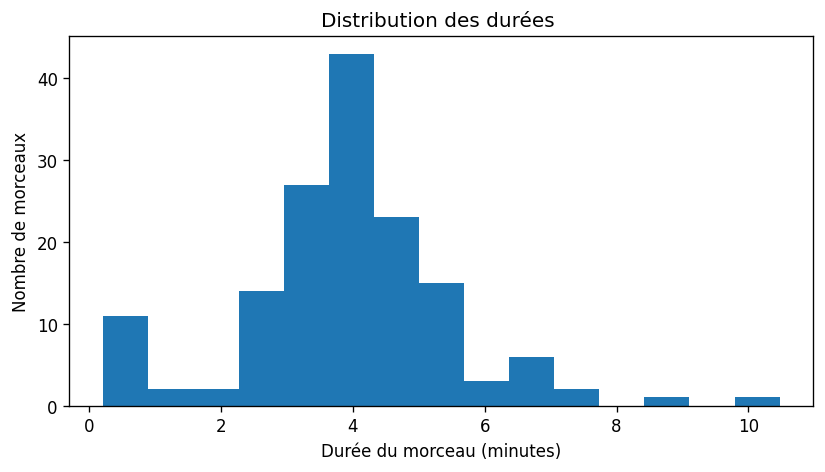

In [8]:
fig, ax = plt.subplots()
ax.hist(df_tracks["duration_min"], bins=15)
ax.set_xlabel("Durée du morceau (minutes)")
ax.set_ylabel("Nombre de morceaux")
ax.set_title("Distribution des durées ")
plt.show()


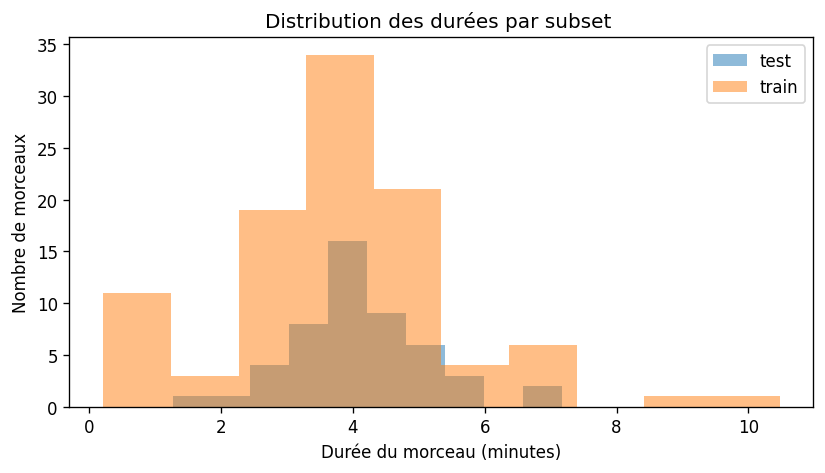

In [9]:
fig, ax = plt.subplots()
for subset_name, group in df_tracks.groupby("subset"):
    ax.hist(group["duration_min"], bins=10, alpha=0.5, label=subset_name)

ax.set_xlabel("Durée du morceau (minutes)")
ax.set_ylabel("Nombre de morceaux")
ax.set_title("Distribution des durées par subset ")
ax.legend()
plt.show()


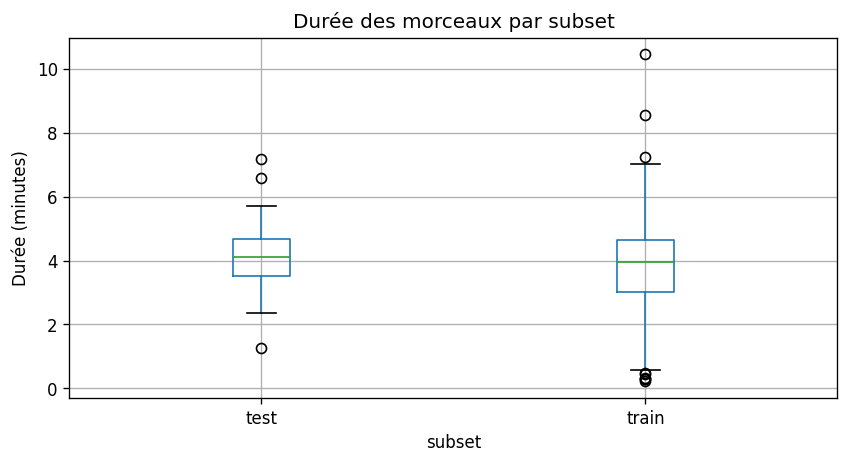

In [10]:
fig, ax = plt.subplots()
df_tracks.boxplot(column="duration_min", by="subset", ax=ax)
ax.set_ylabel("Durée (minutes)")
ax.set_title("Durée des morceaux par subset")
plt.suptitle("")
plt.show()


**Visualisation audio  pour un morceau:**

In [6]:
mus_train = musdb.DB(root=str(MUSDB_ROOT), subsets="train", is_wav=False)
example_track = mus_train[0]

print("Exemple de morceau :", example_track.name)
print("Chemin :", example_track.path)
print("Sample rate :", example_track.rate)

S = example_track.stems  # tensor (5,T,2)
sr = example_track.rate
S.shape


Exemple de morceau : A Classic Education - NightOwl
Chemin : musdb18\train\A Classic Education - NightOwl.stem.mp4
Sample rate : 44100


(5, 7552000, 2)

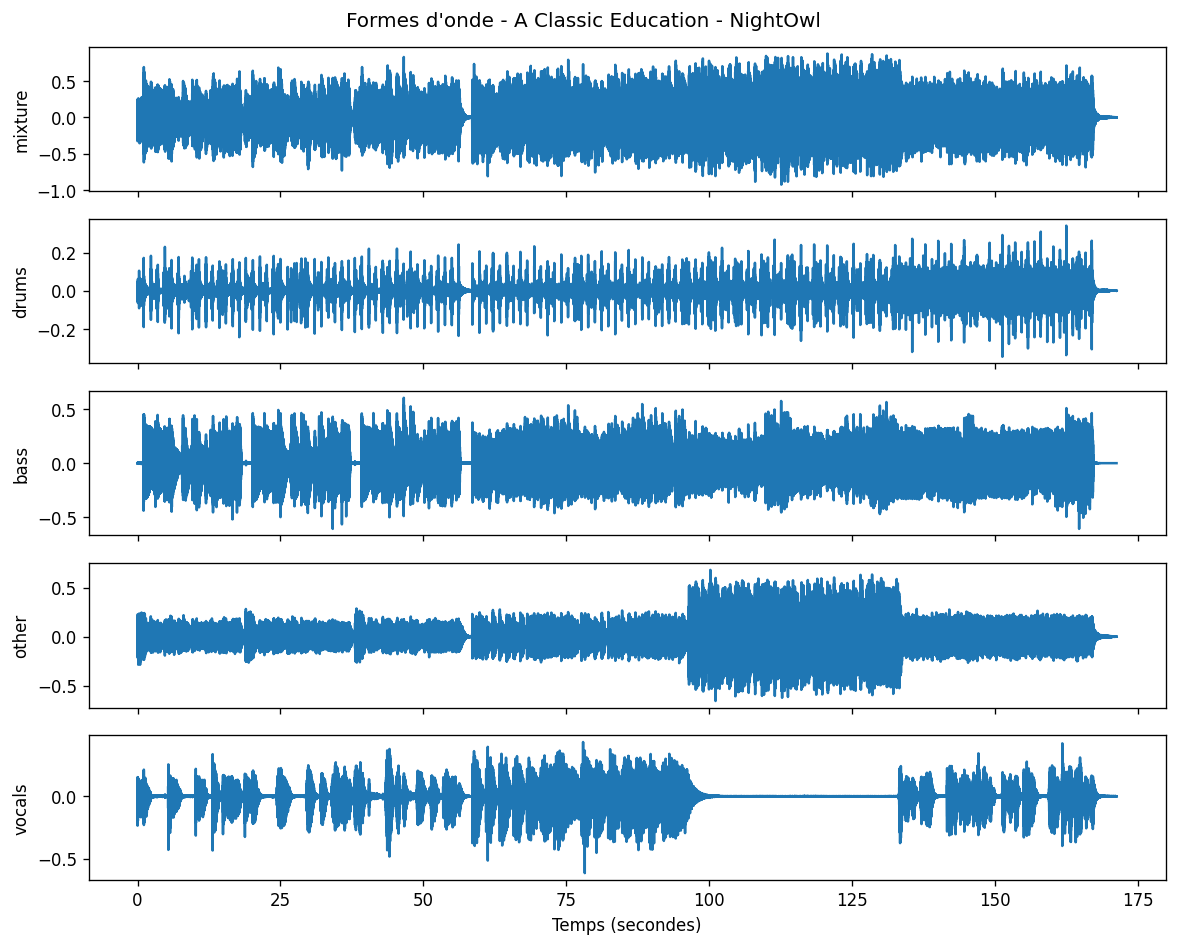

In [8]:
stem_names = ["mixture", "drums", "bass", "other", "vocals"]
nb_samples = S.shape[1]
time_axis = np.arange(nb_samples) / sr

fig, axes = plt.subplots(len(stem_names), 1, figsize=(10, 8), sharex=True)
fig.suptitle(f"Formes d'onde - {example_track.name}")

for i, (name, ax) in enumerate(zip(stem_names, axes)):
    wave = S[i, :, 0]
    ax.plot(time_axis, wave)
    ax.set_ylabel(name)

axes[-1].set_xlabel("Temps (secondes)")
plt.tight_layout()
plt.show()


**Spectrogrammes log-mel sur un extrait:**

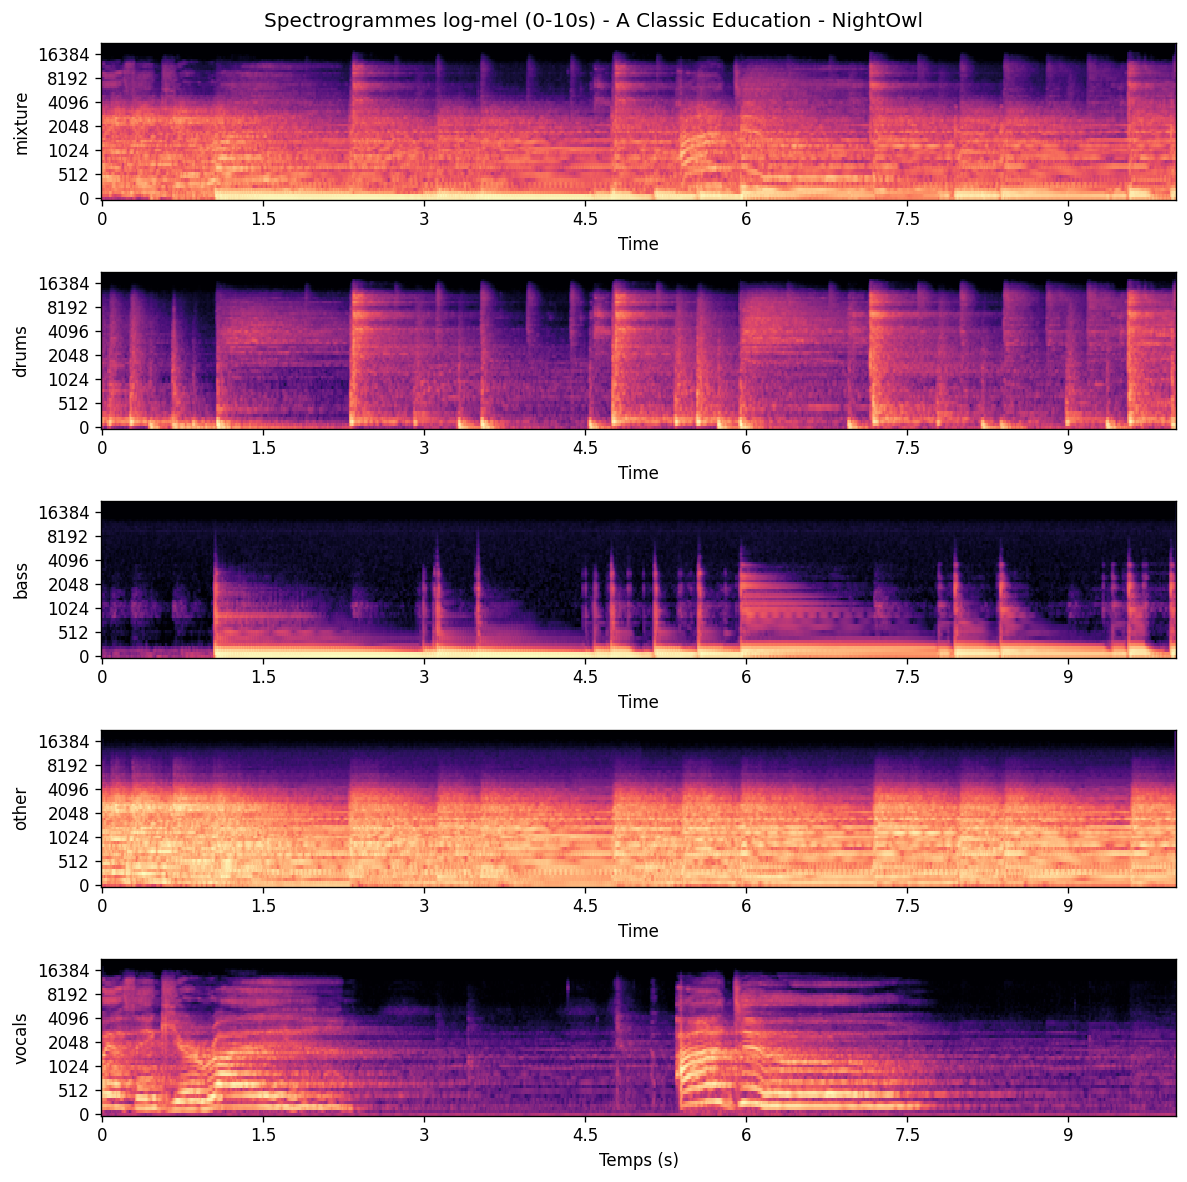

In [9]:
duration = 10.0  # secondes
N_SAMPLES = int(duration * sr)

y_stems = [S[i, :N_SAMPLES, 0] for i in range(len(stem_names))]

def compute_logmel(y, sr=sr, n_mels=64, n_fft=2048, hop_length=512):
    S_lin = librosa.feature.melspectrogram(
        y=y,
        sr=sr,
        n_fft=n_fft,
        hop_length=hop_length,
        n_mels=n_mels,
        power=2.0,
    )
    S_db = librosa.power_to_db(S_lin, ref=np.max)
    return S_db

logmels = [compute_logmel(y) for y in y_stems]

fig, axes = plt.subplots(len(stem_names), 1, figsize=(10, 10))
fig.suptitle(f"Spectrogrammes log-mel (0-{duration:.0f}s) - {example_track.name}")

for i, (name, S_db, ax) in enumerate(zip(stem_names, logmels, axes)):
    img = librosa.display.specshow(S_db,sr=sr,x_axis="time",y_axis="mel",ax=ax)
    ax.set_ylabel(name)

axes[-1].set_xlabel("Temps (s)")
plt.tight_layout()
plt.show()


**Analyse de l'énergie par instrument (RMS et ratios) :**

In [12]:
max_tracks = None  

def compute_rms(x: np.ndarray) -> float:
    return float(np.sqrt(np.mean(x**2)))

def collect_energy_stats(mus_db, subset_name, max_tracks=None):
    rows = []
    it = mus_db
    if max_tracks is not None:
        it = [mus_db[i] for i in range(min(max_tracks, len(mus_db)))]
    
    for track in tqdm(it, desc=f"Énergie {subset_name}"):
        stems = track.stems  # (5, T, C)
        sr = track.rate

        rms_mix = compute_rms(stems[0])
        rms_drums = compute_rms(stems[1])
        rms_bass = compute_rms(stems[2])
        rms_other = compute_rms(stems[3])
        rms_vocals = compute_rms(stems[4])

        row = dict(
            name=track.name,
            subset=subset_name,
            rms_mix=rms_mix,
            rms_drums=rms_drums,
            rms_bass=rms_bass,
            rms_other=rms_other,
            rms_vocals=rms_vocals,
        )
        rows.append(row)
    return rows

mus_train = musdb.DB(root=str(MUSDB_ROOT), subsets="train", is_wav=False)
mus_test = musdb.DB(root=str(MUSDB_ROOT), subsets="test", is_wav=False)

rows_energy_train = collect_energy_stats(mus_train, "train", max_tracks=max_tracks)
rows_energy_test = collect_energy_stats(mus_test, "test", max_tracks=max_tracks)

df_energy = pd.DataFrame(rows_energy_train + rows_energy_test)

for stem in ["drums", "bass", "other", "vocals"]:
    df_energy[f"ratio_{stem}"] = df_energy[f"rms_{stem}"] / (df_energy["rms_mix"] + 1e-12)

df_energy.head()


Énergie test: 100%|██████████| 50/50 [02:53<00:00,  3.48s/it]


,name,subset,rms_mix,rms_drums,rms_bass,rms_other,rms_vocals,ratio_drums,ratio_bass,ratio_other,ratio_vocals
0,A Classic Education - NightOwl,train,0.163526,0.021582,0.131327,0.084497,0.044537,0.131982,0.803099,0.516717,0.272352
1,ANiMAL - Clinic A,train,0.141315,0.043334,0.099784,0.075310,0.049825,0.306649,0.706109,0.532928,0.352585
2,ANiMAL - Easy Tiger,train,0.122058,0.068363,0.065417,0.054446,0.056017,0.560085,0.535951,0.446064,0.458939
3,ANiMAL - Rockshow,train,0.115235,0.062892,0.074490,0.040433,0.046744,0.545776,0.646418,0.350877,0.405639
4,Actions - Devil's Words,train,0.157617,0.072260,0.068442,0.077876,0.094348,0.458455,0.434228,0.494087,0.598587


**Distribution de l'énergie RMS par instrument**

In [14]:
df_energy[cols_rms].describe()

NameError: name 'cols_rms' is not defined

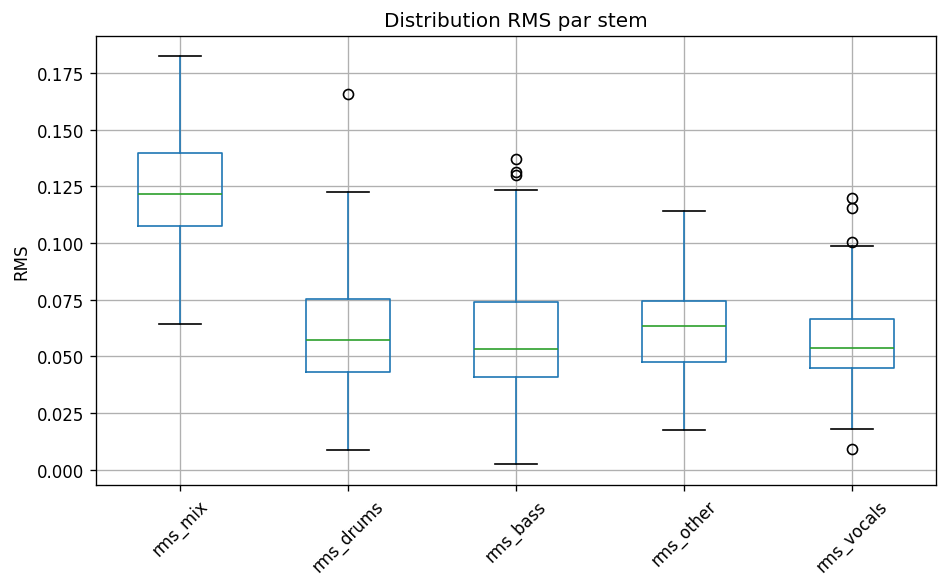

In [15]:
cols_rms = ["rms_mix", "rms_drums", "rms_bass", "rms_other", "rms_vocals"]

fig, ax = plt.subplots(figsize=(8, 5))
df_energy[cols_rms].boxplot(ax=ax)
ax.set_title("Distribution RMS par stem")
ax.set_ylabel("RMS")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**ratios d'énergie par rapport au mix:**

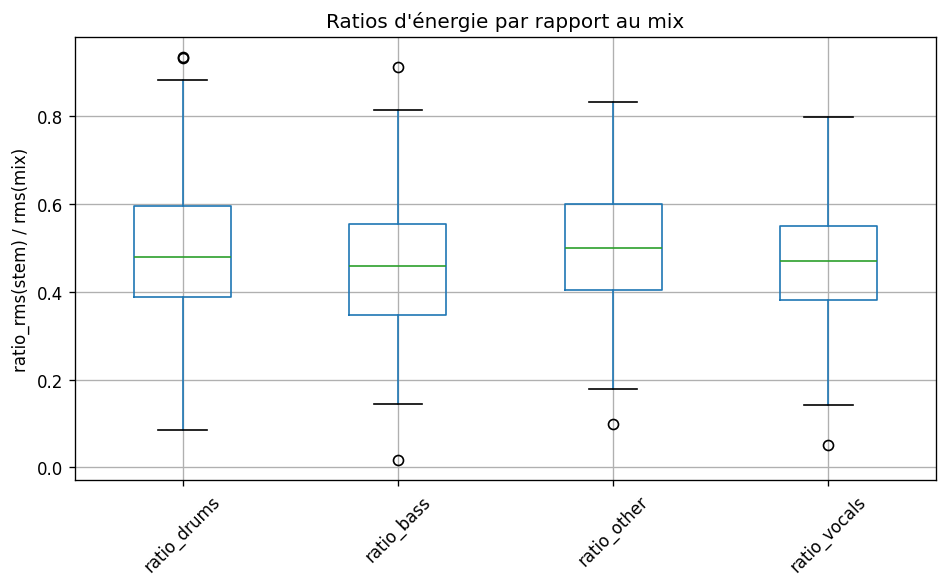

In [16]:
cols_ratio = ["ratio_drums", "ratio_bass", "ratio_other", "ratio_vocals"]

fig, ax = plt.subplots(figsize=(8, 5))
df_energy[cols_ratio].boxplot(ax=ax)
ax.set_title("Ratios d'énergie par rapport au mix")
ax.set_ylabel("ratio_rms(stem) / rms(mix)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [17]:
df_energy[cols_ratio].describe()

,ratio_drums,ratio_bass,ratio_other,ratio_vocals
count,150.000000,150.000000,150.000000,150.000000
mean,0.484373,0.464229,0.501794,0.464676
std,0.159184,0.155947,0.146955,0.124648
min,0.085694,0.017190,0.099626,0.052049
25%,0.387328,0.347803,0.404670,0.380572
50%,0.479003,0.458494,0.500413,0.471037
75%,0.595475,0.553997,0.599554,0.550661
max,0.933959,0.912003,0.832105,0.797420


**Summary**

In [ ]:
summary = f"""- Nombre de morceaux : {len(df_tracks)} (train={len_train}, test={len_test})
- Durée totale = {total_hours:.2f} heures
- Durée moyenne des morceaux = {df_tracks['duration_min'].mean():.2f} minutes

Énergie (RMS) moyenne par instrument (ratio sur le mix) : {df_energy[['ratio_drums','ratio_bass','ratio_other','ratio_vocals']].mean().to_string()}

"""

print(summary)


- Nombre de morceaux : 150 (train=100, test=50)
- Durée totale = 9.81 heures
- Durée moyenne des morceaux = 3.93 minutes

Énergie (RMS) moyenne par instrument (ratio sur le mix) : ratio_drums     0.484373
ratio_bass      0.464229
ratio_other     0.501794
ratio_vocals    0.464676



Observations qualitatives :
- 'other' (accompagnement) est souvent la source dominante en énergie.
- 'drums' et 'bass' contribuent fortement mais de manière plus variable.
- 'vocals' montrent une grande variabilité (morceaux instrumentaux, passages sans voix, etc.).

# exploration dataset généré

 Exploration du dataset généré 

 Objectifs :
 - Inspecter la structure des fichiers .npz (X, Y, T)
 - Mesurer la taille du dataset (nb de fenêtres, par split, par track)
 - Analyser la répartition des labels (voix, batterie, basse)
 - Analyser les combinaisons multilabel (000, 001, 010, ..., 111)



In [21]:
DATA_ROOT = Path("prepared_musdb18_0.25")  


In [22]:
train_files = sorted((DATA_ROOT / "train").glob("*.npz"))
test_files = sorted((DATA_ROOT / "test").glob("*.npz"))

print(f"Nb fichiers train : {len(train_files)}")
print(f"Nb fichiers test  : {len(test_files)}")

train_files[:5]


Nb fichiers train : 100
Nb fichiers test  : 50


[WindowsPath('prepared_musdb18_0.25/train/A Classic Education - NightOwl.npz'),
 WindowsPath("prepared_musdb18_0.25/train/Actions - Devil's Words.npz"),
 WindowsPath('prepared_musdb18_0.25/train/Actions - One Minute Smile.npz'),
 WindowsPath('prepared_musdb18_0.25/train/Actions - South Of The Water.npz'),
 WindowsPath('prepared_musdb18_0.25/train/Aimee Norwich - Child.npz')]

**Inspection d'un fichier exemple:**

In [23]:
example_file = train_files[0]
print("Exemple fichier :", example_file)

d = np.load(example_file, allow_pickle=True)
list(d.keys())


Exemple fichier : prepared_musdb18_0.25\train\A Classic Education - NightOwl.npz


['X',
 'Y',
 'T',
 'sr',
 'win_sec',
 'hop_sec',
 'n_fft',
 'mel_hop',
 'n_mels',
 'min_mix_rms',
 'stem_abs_thr',
 'ratio_thr_vocals',
 'ratio_thr_drums',
 'ratio_thr_bass',
 'track_name']

In [24]:
X = d["X"]   # (N, n_mels, frames)
Y = d["Y"]   # (N, 3)
T = d["T"]   # (N,)

print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("T shape:", T.shape)

print("Meta :")
for key in ["sr", "win_sec", "hop_sec", "n_fft", "mel_hop",
            "n_mels", "min_mix_rms", "stem_abs_thr",
            "ratio_thr_vocals", "ratio_thr_drums", "ratio_thr_bass",
            "track_name"]:
    if key in d:
        print(f"{key}: {d[key]}")


X shape: (685, 64, 22)
Y shape: (685, 3)
T shape: (685,)
Meta :
sr: 22050
win_sec: 0.25
hop_sec: 0.25
n_fft: 1024
mel_hop: 256
n_mels: 64
min_mix_rms: 0.0001
stem_abs_thr: 0.002
ratio_thr_vocals: 0.15
ratio_thr_drums: 0.25
ratio_thr_bass: 0.3
track_name: A Classic Education - NightOwl


**Taille du dataset**


In [25]:

def summarize_split(npz_files):
    rows = []
    for f in npz_files:
        d = np.load(f, allow_pickle=True)
        X = d["X"]
        Y = d["Y"]
        T = d["T"]
        name = str(d.get("track_name", f.stem))
        rows.append({
            "file": f.name,
            "track_name": name,
            "N_windows": X.shape[0],
        })
    return pd.DataFrame(rows)

df_train = summarize_split(train_files)
df_test = summarize_split(test_files)

print("Train:")
display(df_train.head())
print("Test:")
display(df_test.head())


Train:


,file,track_name,N_windows
0,A Classic Education - NightOwl.npz,A Classic Education - NightOwl,685
1,Actions - Devil's Words.npz,Actions - Devil's Words,779
2,Actions - One Minute Smile.npz,Actions - One Minute Smile,646
3,Actions - South Of The Water.npz,Actions - South Of The Water,692
4,Aimee Norwich - Child.npz,Aimee Norwich - Child,705


Test:


,file,track_name,N_windows
0,Al James - Schoolboy Facination.npz,Al James - Schoolboy Facination,796
1,AM Contra - Heart Peripheral.npz,AM Contra - Heart Peripheral,807
2,Angels In Amplifiers - I'm Alright.npz,Angels In Amplifiers - I'm Alright,709
3,Arise - Run Run Run.npz,Arise - Run Run Run,865
4,Ben Carrigan - We'll Talk About It All Tonight...,Ben Carrigan - We'll Talk About It All Tonight,929


In [ ]:
print("Résumé nb fenêtres (train):")
display(df_train["N_windows"].describe())

print("Résumé nb fenêtres (test):")
display(df_test["N_windows"].describe())

total_train = df_train["N_windows"].sum()
total_test = df_test["N_windows"].sum()
print(f"Total fenêtres train : {total_train}")
print(f"Total fenêtres test  : {total_test}")


Résumé nb fenêtres (train):


count     100.000000
mean      893.590000
std       421.658009
min        51.000000
25%       704.000000
50%       899.500000
75%      1103.500000
max      2513.000000
Name: N_windows, dtype: float64


Résumé nb fenêtres (test):


count      50.000000
mean      971.720000
std       248.586784
min       281.000000
25%       816.000000
50%       944.500000
75%      1096.000000
max      1706.000000
Name: N_windows, dtype: float64


Total fenêtres train : 89359
Total fenêtres test  : 48586


**nombre de fenêtres par track:**

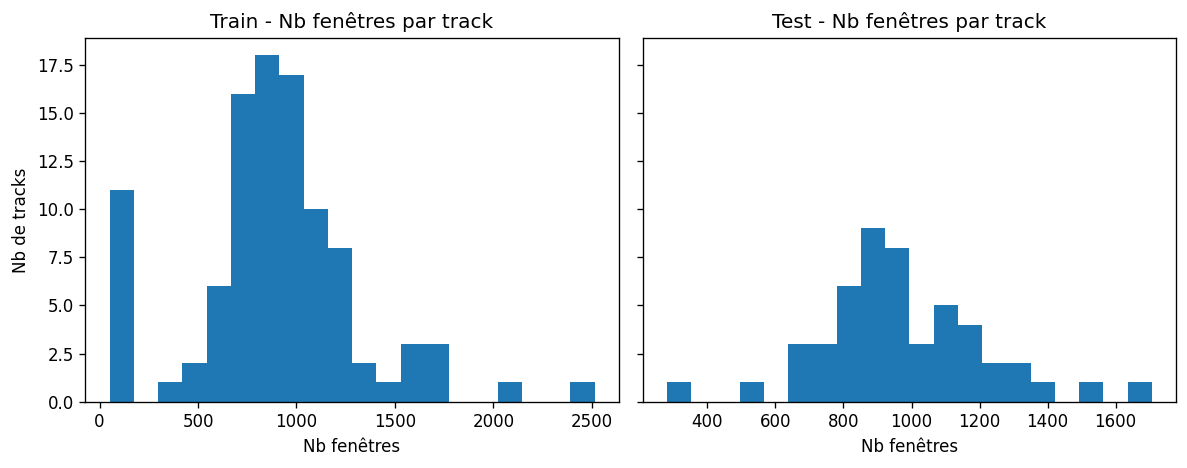

In [26]:

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

axes[0].hist(df_train["N_windows"], bins=20)
axes[0].set_title("Train - Nb fenêtres par track")
axes[0].set_xlabel("Nb fenêtres")
axes[0].set_ylabel("Nb de tracks")

axes[1].hist(df_test["N_windows"], bins=20)
axes[1].set_title("Test - Nb fenêtres par track")
axes[1].set_xlabel("Nb fenêtres")

plt.tight_layout()
plt.show()


**Répartition des labels:**

In [27]:

def load_all_Y(npz_files):
    Ys = []
    for f in npz_files:
        d = np.load(f, allow_pickle=True)
        Ys.append(d["Y"])
    if not Ys:
        return np.zeros((0, 3), dtype=np.int8)
    return np.concatenate(Ys, axis=0)

Y_train = load_all_Y(train_files)
Y_test = load_all_Y(test_files)

print("Y_train shape:", Y_train.shape)
print("Y_test shape :", Y_test.shape)


Y_train shape: (89359, 3)
Y_test shape : (48586, 3)


In [28]:
def label_stats(Y, split_name=""):
    col_names = ["vocals", "drums", "bass"]
    print(f"{split_name} :")
    N = Y.shape[0]
    for i, name in enumerate(col_names):
        freq = Y[:, i].mean()
        print(f"{name:6s}: {freq:.3f} (soit {freq*100:.1f} % des fenêtres)")

label_stats(Y_train, "TRAIN")
print()
label_stats(Y_test, "TEST")


TRAIN :
vocals: 0.562 (soit 56.2 % des fenêtres)
drums : 0.566 (soit 56.6 % des fenêtres)
bass  : 0.692 (soit 69.2 % des fenêtres)

TEST :
vocals: 0.572 (soit 57.2 % des fenêtres)
drums : 0.659 (soit 65.9 % des fenêtres)
bass  : 0.612 (soit 61.2 % des fenêtres)


**fréquences de présence par instrument:**

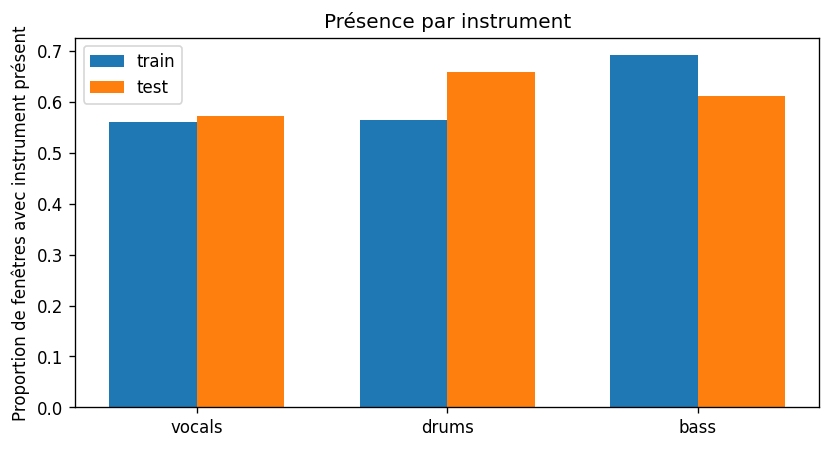

In [29]:

col_names = ["vocals", "drums", "bass"]

freq_train = Y_train.mean(axis=0)
freq_test = Y_test.mean(axis=0)

x = np.arange(len(col_names))
width = 0.35

fig, ax = plt.subplots()
ax.bar(x - width/2, freq_train, width, label="train")
ax.bar(x + width/2, freq_test, width, label="test")
ax.set_xticks(x)
ax.set_xticklabels(col_names)
ax.set_ylabel("Proportion de fenêtres avec instrument présent")
ax.set_title("Présence par instrument")
ax.legend()
plt.show()


**Combinaisons multilabel:**

In [30]:
from collections import Counter
def combo_counts(Y):
    combos = ["".join(map(str, row)) for row in Y]
    counter = Counter(combos)
    total = len(combos)
    rows = []
    for pattern in sorted(counter.keys()):
        c = counter[pattern]
        rows.append({
            "pattern": pattern,
            "count": c,
            "freq": c / total
        })
    return pd.DataFrame(rows).sort_values("freq", ascending=False)

df_combo_train = combo_counts(Y_train)
df_combo_test = combo_counts(Y_test)

print("Combinaisons TRAIN :")
display(df_combo_train)

print("\nCombinaisons TEST :")
display(df_combo_test)


Combinaisons TRAIN :


,pattern,count,freq
7,111,21507,0.240681
3,011,16864,0.188722
5,101,13444,0.150449
1,001,10012,0.112042
4,100,8318,0.093085
0,000,7040,0.078783
6,110,6914,0.077373
2,010,5260,0.058864



Combinaisons TEST :


,pattern,count,freq
7,111,11750,0.241839
3,011,8851,0.182172
6,110,6945,0.142942
5,101,5393,0.110999
2,010,4487,0.092352
1,001,3728,0.076730
4,100,3726,0.076689
0,000,3706,0.076277


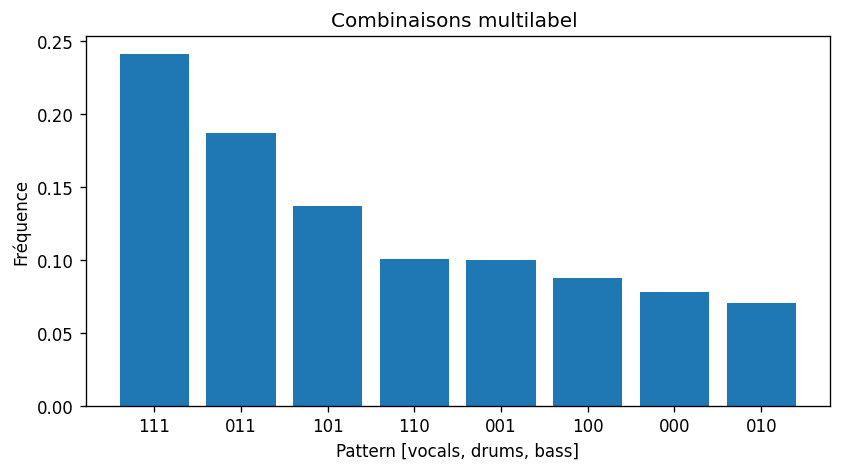

In [31]:

Y_all = np.concatenate([Y_train, Y_test], axis=0)

df_combo_all = combo_counts(Y_all) 

fig, ax = plt.subplots()
ax.bar(df_combo_all["pattern"], df_combo_all["freq"])
ax.set_xlabel("Pattern [vocals, drums, bass]")
ax.set_ylabel("Fréquence")
ax.set_title("Combinaisons multilabel ")
plt.show()


**timeline de labels pour un track: exemple avec le premier fichier train**

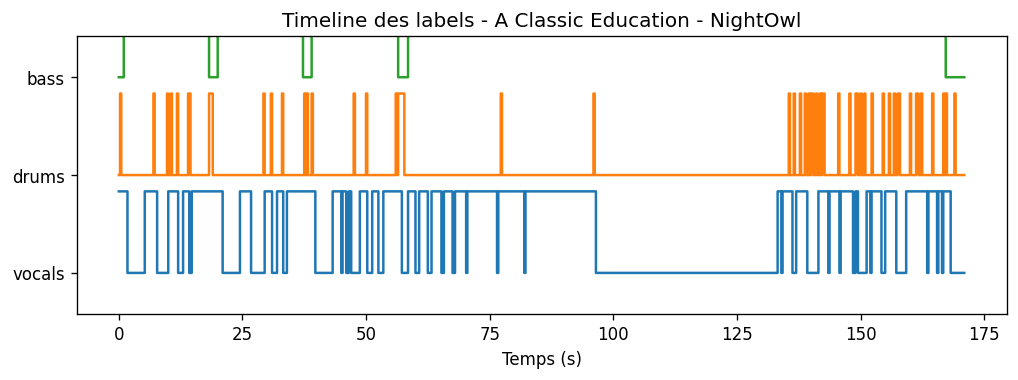

In [32]:
def plot_timeline_for_file(npz_path):
    d = np.load(npz_path, allow_pickle=True)
    Y = d["Y"]  # (N,3)
    T = d["T"]  # (N,)
    name = d.get("track_name", npz_path.stem)

    col_names = ["vocals", "drums", "bass"]
    fig, ax = plt.subplots(figsize=(10, 3))
    for i, label in enumerate(col_names):
        ax.step(T, Y[:, i] + i*1.2, where="post", label=label)
    ax.set_xlabel("Temps (s)")
    ax.set_yticks([0, 1.2, 2.4])
    ax.set_yticklabels(col_names)
    ax.set_title(f"Timeline des labels - {name}")
    ax.set_ylim(-0.5, 2.9)
    plt.show()

plot_timeline_for_file(train_files[0])


In [39]:
Y_all = np.concatenate([Y_train, Y_test], axis=0)
print("Shape total :", Y_all.shape)

col_names = ["vocals", "drums", "bass"]
for i, name in enumerate(col_names):
    freq = Y_all[:, i].mean()
    print(f"{name:6s}: {freq:.3f}   ({freq*100:.1f} % des fenêtres)")


Shape total : (137945, 3)
vocals: 0.565   (56.5 % des fenêtres)
drums : 0.599   (59.9 % des fenêtres)
bass  : 0.664   (66.4 % des fenêtres)


In [40]:
for i,name in enumerate(col_names):
    freq_train = Y_train[:, i].mean()
    freq_test = Y_test[:, i].mean()
    print(f"{name:6s}: train={freq_train:.3f} ({freq_train*100:.1f} %), test={freq_test:.3f} ({freq_test*100:.1f} %)")


vocals: train=0.562 (56.2 %), test=0.572 (57.2 %)
drums : train=0.566 (56.6 %), test=0.659 (65.9 %)
bass  : train=0.692 (69.2 %), test=0.612 (61.2 %)
